In [247]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [248]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [249]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [250]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42) 
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [352]:
#Let's train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
             xmean = x.mean(0, keepdim=True) #batch mean 
             xvar = x.var(0, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar +self.eps) #normalize to unit variance
        self.out =  self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return[]

n_embd = 10 #the dimensionality of the character embeding vectors
n_hidden = 100 #the number of the neurons in the  hidden layer of the MLP 
g = torch.Generator().manual_seed(2147483647) #for reproductibility 

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size),  BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confident # no Batchnorm used
    #layers[-1].weight *= 0.1

    #in case of batchnorm making last layer: make less confident 
    #we have to change the gamma, see Batchnorm output
    layers[-1].gamma *=0.1
    
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total 
for p in parameters:
    p.requires_grad = True



47551


In [354]:
# just printing the parameters list elements one by one

# for layer in layers:
# #     print('layer.parameters', layer.parameters())
#     for p in layer.parameters():
#         print(p.shape)
#     break
# i = 1
# for p in parameters:
#     print(p.shape)
#     if i == 2:
#         break
#     i+=1


In [355]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = [] #ud in Andrej's code

for i in range(max_steps):
    
    #minibatch consrtuct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    #forward pass 
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], - 1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #After_debug: would take out retain_graph
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() 
                                                                    for p in parameters])
#         print('----------------')
#         for u in update_to_data_ratio:
#             print('len',len(u))
#             print(u)
#         if i >=2:
#             break;
    
    if i >=1000:
        break #After_debug: would take out to run full optimization  

      0/ 200000: 3.2870


In [347]:
# #trials code with histograms #todo delete later
# hy, hx = torch.histogram(torch.tensor([1., 2., 1., 2., 14.]),bins=4,density=True)
# #1D Tensor containing the values of the histogram.
# #bin_edges(Tensor): 1D Tensor containing the edges of the histogram bins.

# print(f'hy: {hy}')
# print(f'hx: {hx}')
# plt.figure(figsize=(20, 4)) #width  and height of the plot
# plt.plot(hx[:-1].detach(), hy.detach())
# print(f'hy.shape:{hy.shape}')

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

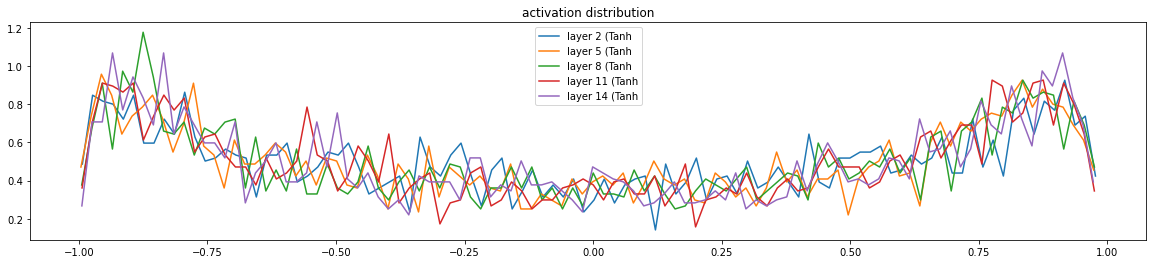

In [356]:
# visualize histograms
plt.figure(figsize=(20, 4)) #width  and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
#         print(f't: {t.shape, t}')
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' 
              % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() *100))
        hy, hx = torch.histogram(t, density=True)
#         print(f"hy:{hy}")
#         print(f"hx:{hx}")
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
        abst = t.abs() > 0.97
#         break;
plt.legend(legends);
plt.title('activation distribution')
        

layer 2 (      Tanh): mean +0.000000, std 3.682950e-03
layer 5 (      Tanh): mean +0.000000, std 3.262606e-03
layer 8 (      Tanh): mean -0.000000, std 2.973727e-03
layer 11 (      Tanh): mean -0.000000, std 2.741106e-03
layer 14 (      Tanh): mean +0.000000, std 2.584292e-03


Text(0.5, 1.0, 'gradient distribution')

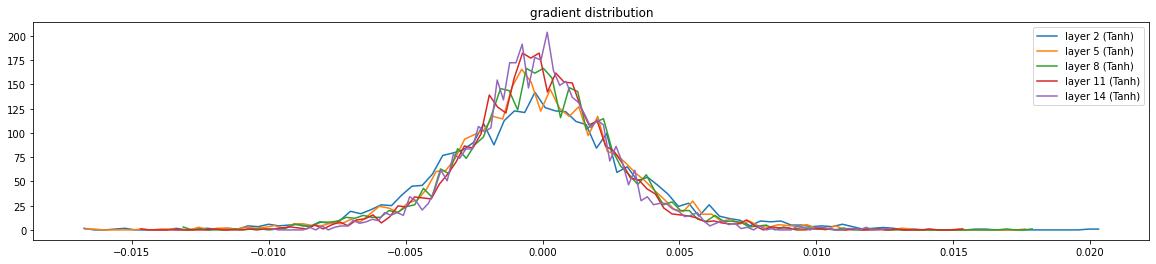

In [357]:
# visualize histograms 
plt.figure(figsize =(20,4)) #width and height of the plot
legends = []
for i, layer  in enumerate(layers[:-1]): #exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' 
              % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | grd mean +0.000000 | grd std 1.019883e-02 | grad: data ratio 1.018844e-02
weight  (30, 100) | grd mean +0.000092 | grd std 8.238418e-03 | grad: data ratio 2.635835e-02
weight (100, 100) | grd mean +0.000031 | grd std 7.318098e-03 | grad: data ratio 4.377136e-02
weight (100, 100) | grd mean -0.000019 | grd std 6.662017e-03 | grad: data ratio 3.949892e-02
weight (100, 100) | grd mean -0.000019 | grd std 5.821509e-03 | grad: data ratio 3.468157e-02
weight (100, 100) | grd mean +0.000053 | grd std 5.445288e-03 | grad: data ratio 3.243363e-02
weight  (100, 27) | grd mean -0.000165 | grd std 1.046843e-02 | grad: data ratio 6.281254e-02


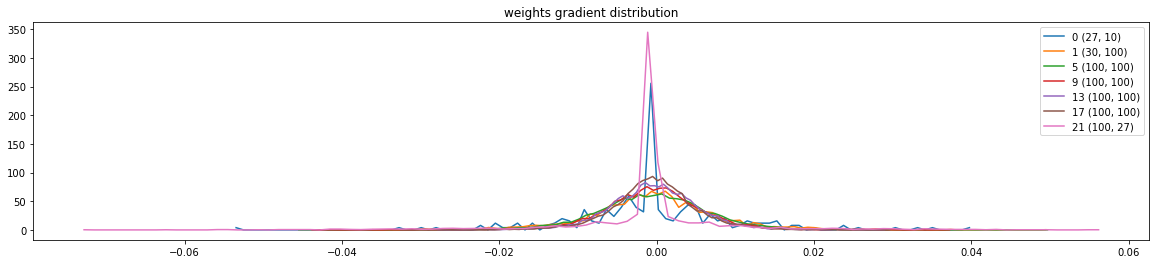

In [358]:
# visualize histograms : weights gradient distribution
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: #looking at the weights
        print('weight %10s | grd mean %+f | grd std %e | grad: data ratio %e' 
              % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
        

i:0 p.shape torch.Size([27, 10])
range(0, 1001)
i:1 p.shape torch.Size([30, 100])
range(0, 1001)
i:5 p.shape torch.Size([100, 100])
range(0, 1001)
i:9 p.shape torch.Size([100, 100])
range(0, 1001)
i:13 p.shape torch.Size([100, 100])
range(0, 1001)
i:17 p.shape torch.Size([100, 100])
range(0, 1001)
i:21 p.shape torch.Size([100, 27])
range(0, 1001)


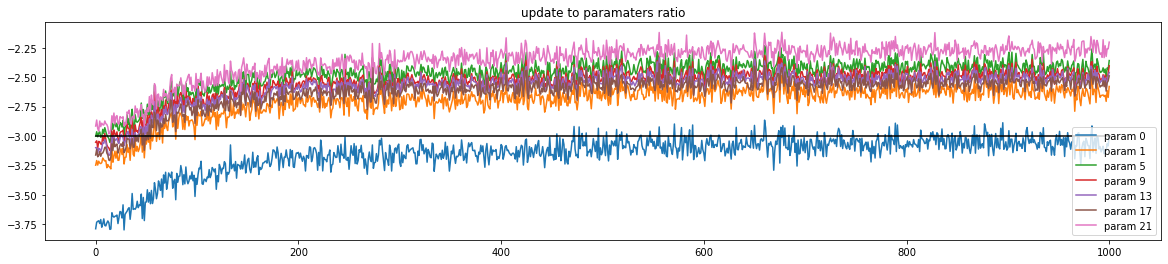

In [359]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        print(f'i:{i} p.shape {p.shape}')
        print(range(len(update_to_data_ratio)))
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append('param %d' %i)
plt.plot([0, len(update_to_data_ratio)], [-3,-3], 'k') #these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('update to paramaters ratio');
